# Crossvalidation Lab


In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
# Even though we are not using seaborn we can style the plots with it
sns.set_style("darkgrid")
pd.set_option('display.max_columns', 500)
# When printing arrays, set_printoptions controls the format
np.set_printoptions(precision=3)
# choose a scorer
sc = make_scorer(mean_squared_error)
# pick a seed
seed=0

## 1. Loading a data set a building a model

In [304]:
# Read in subset of footballer data (we want to predict "overall")
data = pd.read_csv('footballer_reduced.csv')
data.head()

,age,height_cm,weight_kg,work_rate_att,overall
0,20,175,70,Medium,58
1,29,183,80,High,65
2,35,183,78,High,67
3,24,178,72,Medium,69
4,23,173,73,Medium,70


In [305]:
# model_data.describe()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            360 non-null    int64 
 1   height_cm      360 non-null    int64 
 2   weight_kg      360 non-null    int64 
 3   work_rate_att  360 non-null    object
 4   overall        360 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 14.2+ KB


In [306]:
data.work_rate_att.value_counts()
# in linear regression a label with > 5% of instances is statistically significant

Medium    266
High       71
Low        23
Name: work_rate_att, dtype: int64

In [307]:
# Turn category into numeric variables
# Label Encoding with sklearn LabelEncoder()
dataLE = data.copy()
label_encoder = preprocessing.LabelEncoder()
dataLE['work_rate_att']= label_encoder.fit_transform(dataLE['work_rate_att'])

print(dataLE.loc[dataLE['work_rate_att'] == 0].work_rate_att.count())
print(dataLE.loc[dataLE['work_rate_att'] == 1].work_rate_att.count())
print(dataLE.loc[dataLE['work_rate_att'] == 2].work_rate_att.count())
dataLE.head()

71
23
266


,age,height_cm,weight_kg,work_rate_att,overall
0,20,175,70,2,58
1,29,183,80,0,65
2,35,183,78,0,67
3,24,178,72,2,69
4,23,173,73,2,70


In [308]:
# Turn category into numeric variables
# One-Hot Encoding with sklearn OneHotEncoder()
dataOHE = data.copy()
ohe = preprocessing.OneHotEncoder()

#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = ohe.fit_transform(dataOHE.work_rate_att.values.reshape(-1,1)).toarray()

#To add this back into the original dataframe 
dfOneHot = pd.DataFrame(X, columns = ["work_rate_att_"+str(int(i)) for i in range(3)]) 
dataOHE = pd.concat([dataOHE, dfOneHot], axis=1)

#droping the cwork_rate_att column 
dataOHE = dataOHE.drop(['work_rate_att'], axis=1)

print(dataOHE[(dataOHE['work_rate_att_0'] == 1.0)].work_rate_att_0.count())
print(dataOHE[(dataOHE['work_rate_att_1'] == 1.0)].work_rate_att_1.count())
print(dataOHE[(dataOHE['work_rate_att_2'] == 1.0)].work_rate_att_2.count())

dataOHE.head()

71
23
266


,age,height_cm,weight_kg,overall,work_rate_att_0,work_rate_att_1,work_rate_att_2
0,20,175,70,58,0.0,0.0,1.0
1,29,183,80,65,1.0,0.0,0.0
2,35,183,78,67,1.0,0.0,0.0
3,24,178,72,69,0.0,0.0,1.0
4,23,173,73,70,0.0,0.0,1.0


In [309]:
# Turn category into numeric variables
# One-Hot Encoding with Pandas get_dummies()
model_data = data.copy()
model_data = pd.get_dummies(model_data, drop_first=True) # the dropped one is collinear to the other two

print(model_data[(model_data['work_rate_att_Low'] == 1.0)].work_rate_att_Low.count())
print(model_data[(model_data['work_rate_att_Medium'] == 1.0)].work_rate_att_Medium.count())
model_data.head()

23
266


,age,height_cm,weight_kg,overall,work_rate_att_Low,work_rate_att_Medium
0,20,175,70,58,0,1
1,29,183,80,65,0,0
2,35,183,78,67,0,0
3,24,178,72,69,0,1
4,23,173,73,70,0,1


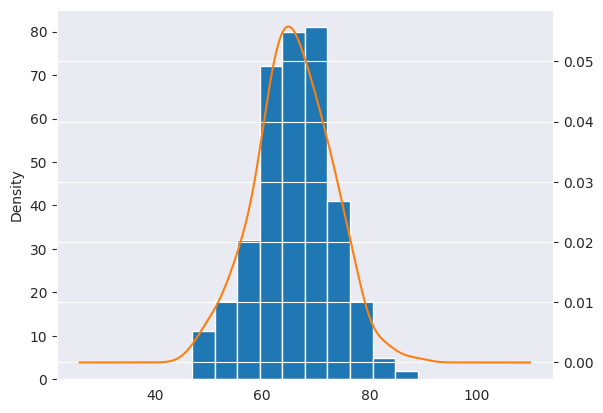

In [310]:
# Create histogram of target variable
ax = model_data.overall.plot(kind='hist')
model_data.overall.plot(kind='kde', ax=ax, secondary_y=True)
plt.show()

In [311]:
# Define our X and y
X = model_data.drop('overall', axis = 'columns')
y = model_data.overall

## 2. Simple train-test split

In [312]:
# Split into train_&_validation and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state=seed)
print(Xtrain.shape, Xtest.shape)

(288, 5) (72, 5)


In [313]:
# Check training and test loss
linmodel = LinearRegression().fit(Xtrain, ytrain)

trainloss = mean_squared_error(ytrain, linmodel.predict(Xtrain))
print(f"Training loss: %.3f" %  trainloss)

testloss = mean_squared_error(ytest, linmodel.predict(Xtest))
print(f"Training loss: %.3f" % testloss)

Training loss: 33.230
Training loss: 40.952


## 3. Crossvalidation: define the partitions
For more details, see [this.](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

For classification with unbalanced classes:
[StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

In [314]:
# Define Kfold crossvalidation 
x = np.arange(20)
print(x,'\n')
kf = KFold(n_splits=5, shuffle=False)
for train, test in kf.split(x):
    print("Train set: %s, Test set: %s" % (train, test))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] 

Train set: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], Test set: [0 1 2 3]
Train set: [ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19], Test set: [4 5 6 7]
Train set: [ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19], Test set: [ 8  9 10 11]
Train set: [ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19], Test set: [12 13 14 15]
Train set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15], Test set: [16 17 18 19]


In [315]:
# Define Kfold crossvalidation with random shuffling
x=np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
for train,test in kf.split(x):
    print("Train set: %s, Test set: %s" % (train, test))

Train set: [ 0  1  3  4  5  6  7  8  9 10 12 13 15 16 17 19], Test set: [ 2 11 14 18]
Train set: [ 1  2  3  5  8  9 10 11 12 13 14 15 16 17 18 19], Test set: [0 4 6 7]
Train set: [ 0  1  2  4  5  6  7  8  9 10 11 12 14 16 17 18], Test set: [ 3 13 15 19]
Train set: [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 18 19], Test set: [ 8  9 10 17]
Train set: [ 0  2  3  4  6  7  8  9 10 11 13 14 15 17 18 19], Test set: [ 1  5 12 16]


In [316]:
# Leave One Out crossvalidation.
# Useful for situations when dataset is too small and you cannot afford leaving out a test set, neither hold-out crossvalidation. 
# You will use the average of the parameters of the trained models (per fold) to get your final model.
# You are actually doing cross-validated test set.
x=np.arange(20)
loo = LeaveOneOut()
for train,test in loo.split(x):
    print("%s %s" % (train, test))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0]
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [1]
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [2]
[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [3]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [4]
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [5]
[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19] [6]
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19] [7]
[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19] [8]
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19] [9]
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19] [10]
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19] [11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19] [12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19] [13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19] [14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 1

## 4. Run the crossvalidation

In [317]:
# KFold cross-validated loss without shuffling
nfolds=5
cv_scores = cross_val_score(LinearRegression(), Xtrain, ytrain, scoring=sc, cv=nfolds)

print(f'List of CV loss:', cv_scores)
print(f"Average CV loss: %.3f +/- %.3f" % (cv_scores.mean(), cv_scores.std()))

List of CV loss: [30.107 39.038 33.24  33.382 37.925]
Average CV loss: 34.738 +/- 3.292


In [318]:
# KFold cross-validated loss without shuffling
kf = KFold(n_splits=5, shuffle=False, random_state=None)
cv_scores = cross_val_score(LinearRegression(), Xtrain, ytrain, cv=kf, scoring=sc)

print(f'List of CV loss:', cv_scores)
print(f"Average CV loss: %.3f +/- %.3f" % (cv_scores.mean(), cv_scores.std()))

List of CV loss: [30.107 39.038 33.24  33.382 37.925]
Average CV loss: 34.738 +/- 3.292


In [319]:
# KFold cross-validated loss with shuffling
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_scores = cross_val_score(LinearRegression(), Xtrain, ytrain, cv=kf, scoring=sc)

print(f'List of CV loss:', cv_scores)
print(f"Average CV loss: %.3f +/- %.3f" % (cv_scores.mean(), cv_scores.std()))

List of CV loss: [32.168 32.547 27.698 49.119 31.711]
Average CV loss: 34.649 +/- 7.442


In [320]:
# Leave One Out cross-validated loss
# Use LOO when you have too little data.
# It is not a good choice for the "footballer" dataset, this cell is just for illustration.
kf = LeaveOneOut()
cv_scores = cross_val_score(LinearRegression(), X, y, cv=kf, scoring=sc) # for Leave One Out you use the full data set

# print(f'List of CV loss:', cv_scores)
print(f"Average CV loss: %.3f +/- %.3f" % (cv_scores.mean(), cv_scores.std()))

Average CV loss: 35.832 +/- 50.553
